# AdventureWorks fösälningsanalys
I denna analys undersöker vi AdventureWroks- databasen för att besvara affärsfrågor som exemplvis:
- Produktkategorier och deras försälning
- Försälningstrender över tid
- Regional försälning

Vi använder SQL för att hämta data och Pyhtonför visualisering och analys.

In [165]:
#!/usr/bin/env python3
# Import necessary libraries

import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# Database connection setup

user = "sa"
password = quote_plus("WM271290!")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = f"mssql+pyodbc://{user}:{password}@{server}/{database}?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
engine = create_engine(connection_string)

# Test the connection

try: 
    with engine.connect():
        print("Connection to the database was successful.")
except Exception as e:
    print("An error occurred while connecting to the database:", e)

# Function to execute SQL query and return DataFrame

def query_df(sql:str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

Connection to the database was successful.


C:\Users\wendy\AppData\Local\Temp\ipykernel_2452\2350543793.py:27: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

**Tabeller som används:**
- Production.ProductCategory
- Production.ProductSubCategory
- Production.Product

**Plan:**
1. JOINA tabellerna
2. Räkna DISTINCT produkter per kategori
3. Skapa vertikalt stapeldiagram
4. Analysera resultatet

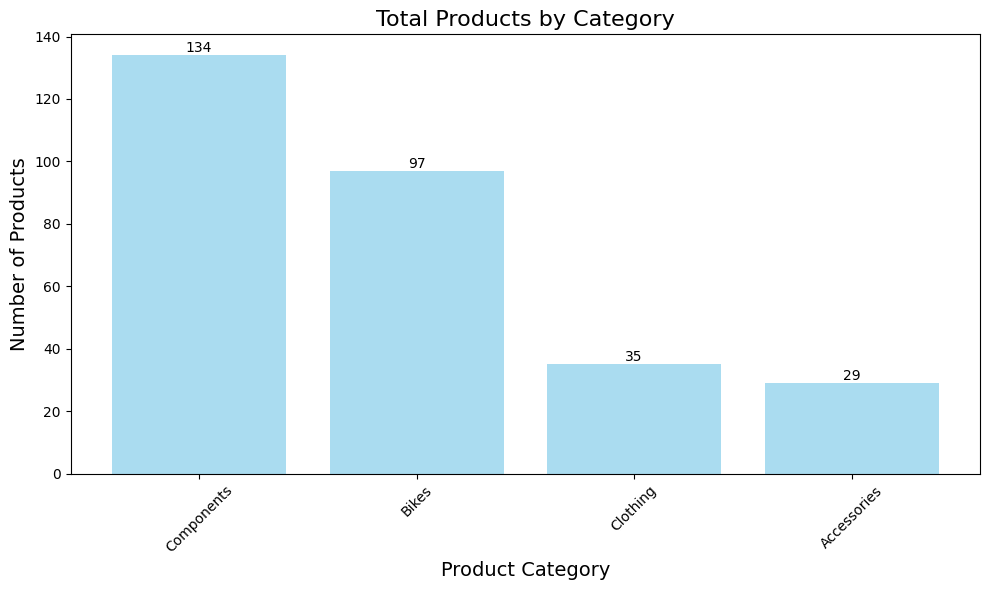

In [166]:
# Visualization 1: Total Products by Category
# SQL Query for Visualization 1

query_vis1 = """
SELECT 
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS TotalProducts

FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY TotalProducts DESC
"""

df_vis1 = query_df(query_vis1)
df_vis1

# Bar Chart for Total Products by Category

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['TotalProducts'], color='skyblue',alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

ax.set_title('Total Products by Category', fontsize=16)
ax.set_xlabel('Product Category', fontsize=14)
ax.set_ylabel('Number of Products', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Insikter - Antal produkt per kategori

Compoents är störasta kategorin med 134 produkter. Accessories är minst med 29 produkter.
Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

**Tabeller som används:**
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

**Plan:**
1. JOINA tabellerna
2. Räkna intäkter per produktkategori
3. Räkna antal ordrar per produktkategori
4. Skapa horisontellt stapeldiagram
5. Analysera resultatet

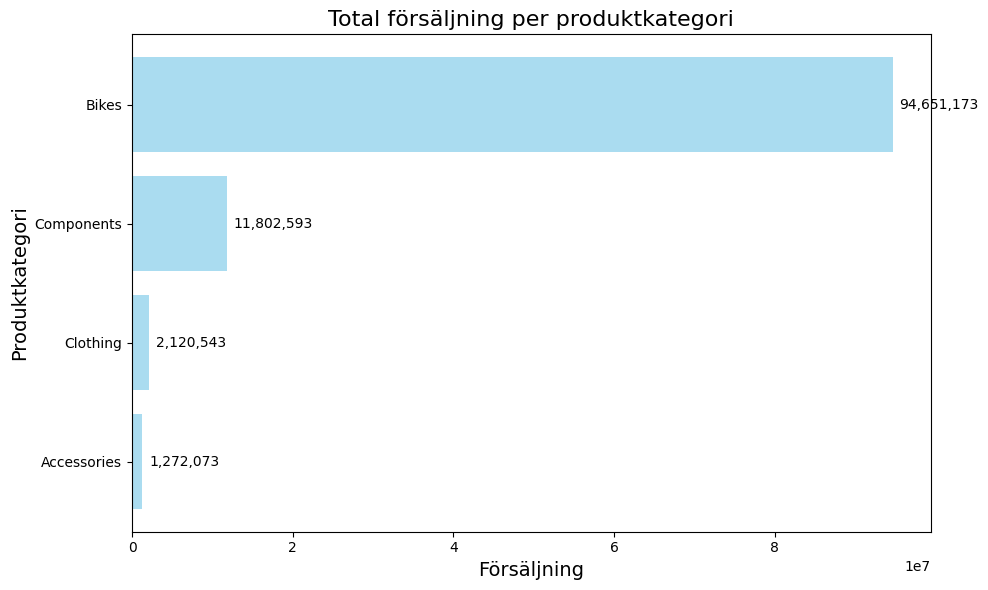

In [167]:
# Visualization 2: Total Sales by Product Category
# SQL Query for Visualization 2

query_vis2 = """
SELECT 
    pc.Name AS CategoryName,
    round(SUM(LineTotal),2) AS TotalRevenue,
    SUM(OrderQty) AS TotalQuantitySold

FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN sales.SalesOrderDetail sod 
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalRevenue ASC;
"""


df_vis2 = query_df(query_vis2)

# Horizontal Bar Chart for Total Sales by Product Category

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalRevenue'], color='skyblue',alpha=0.7,)

ax.bar_label(
    bars,
    labels=[f"{v:,.0f}" for v in df_vis2['TotalRevenue']],
    padding=5
)

ax.set_title('Total försäljning per produktkategori', fontsize=16)
ax.set_ylabel('Produktkategori', fontsize=14)
ax.set_xlabel('Försäljning', fontsize=14)
plt.tight_layout()
plt.show()

## Insikter - Försäljning per produktkategori

Bikes är störasta kategorin med 94,5 Mio intäkt. Accessories är minst med 1,3 Mio intäkt.
- **Bikes står för nästan 86 % av den totala försäljningen**, vilket är en tydlig indikation på att detta är företagets **huvudsakliga fokus och kärnverksamhet**.
- Övriga kategorier (Components, Clothing, Accessories) bidrar tillsammans endast med cirka 14 % av intäkterna, vilket visar att de är **kompletterande produktlinjer** snarare än huvudintäktskällor.

Företagets intäktsstruktur är starkt koncentrerad till **Bikes**, vilket innebär att strategiska beslut, marknadsföring och produktutveckling sannolikt är fokuserade på denna kategori. Övriga kategorier fungerar som stödprodukter som kompletterar huvudverksamheten.

## Visualisering 3: Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?

**Tabeller som används:**
- Sales.SalesOrderHeader

**Plan:**
1. Räkna intäkter per månad
2. Lägg till ett filter för att endast visa de senaste 13 fulla månaderna
3. Skapa linjediagram
4. Analysera resultatet

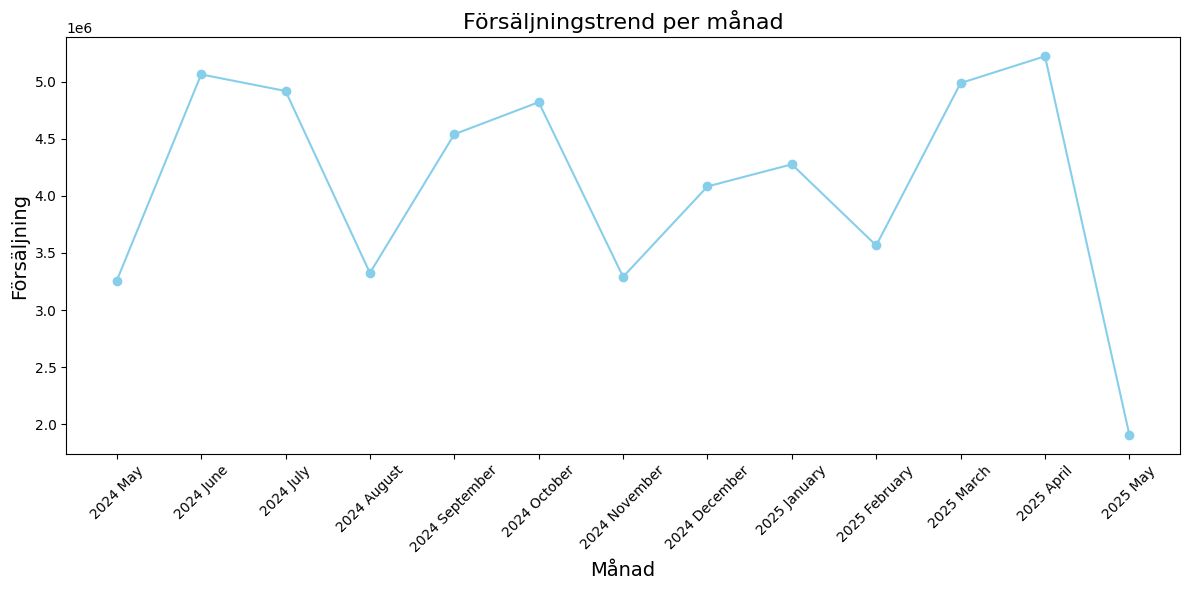

In [168]:
# Visualization 3: Sales Trend Over the Last 12 Months
# SQL Query for Visualization 3

query_vis3 = """
SELECT 
    ROUND(SUM(SubTotal), 2) AS TotalRevenue,
    YEAR(OrderDate) AS [Year],
    RIGHT('00' + CAST(MONTH(OrderDate) AS varchar(2)), 2) AS [Month],
    FORMAT(OrderDate, 'yyyyMM') AS Period,
    FORMAT(OrderDate, 'yyyy MMMM') AS PeriodName
FROM Sales.SalesOrderHeader
WHERE OrderDate >= DATEADD(
        MONTH,
        -13,
        DATEADD(
            MONTH,
            DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
            0
        )
      )
  AND OrderDate < DATEADD(
        MONTH,
        DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
        0
      )
GROUP BY 
    YEAR(OrderDate),
    MONTH(OrderDate),
    FORMAT(OrderDate, 'yyyyMM'),
    FORMAT(OrderDate, 'yyyy MMMM')
ORDER BY Period ASC

"""

df_vis3 = query_df(query_vis3)

# Line Chart for Sales Trend Over the Last 13 Months

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_vis3['PeriodName'], df_vis3['TotalRevenue'], marker='o', linestyle='-', color='skyblue')
ax.set_title('Försäljningstrend per månad', fontsize=16) 
ax.set_xlabel('Månad', fontsize=14)
ax.set_ylabel('Försäljning', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Insikter - Försäljningstrend över tid

Trenden i den månadsvisa försäljningen visar variationer över perioden maj 2024 till maj 2025. Försäljningen **ökar och minskar periodvis**, vilket tyder på viss säsongsvariation.  

- Den **högsta försäljningen** återfinns i **april 2025 (5 222 758,74)**, medan den **lägsta försäljningen** noteras i **maj 2025 (1 908 059,49)**.  
- Sommarmånaderna 2024 (juni–juli) har relativt höga värden, medan augusti 2024 uppvisar en tydlig dipp.  
- Under hösten 2024 ser vi en viss återhämtning (september–oktober), men november 2024 sjunker igen innan december 2024 visar en måttlig ökning.  
- I början av 2025 är försäljningen relativt stabil med en topp i april, följt av en kraftig nedgång i maj. Liknande variationer kan observeras under 2024, där vissa månader sticker ut med högre försäljning följt av lägre värden.

Detta tyder på en **säsongsbetonad trend i köpbeteendet**, där vissa månader genererar högre försäljning än andra. I detta fall följer **maj 2025 direkt efter de två starka månaderna mars och april**, vilket visar att försäljningen kan minska snabbt efter en intensiv period. Företaget bör beakta detta mönster vid planering av lager, marknadsföring och kampanjer.

## Visualisering 4: Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

**Tabeller som används:**
- Sales.SalesOrderHeader

**Plan:**
1. Räkna intäkter per år
2. Räkna antal ordrar per år
3. Räkna genomsnittlig intäkt per order
4. Skapa tre separata stapeldiagram per år
5. Analysera resultatet

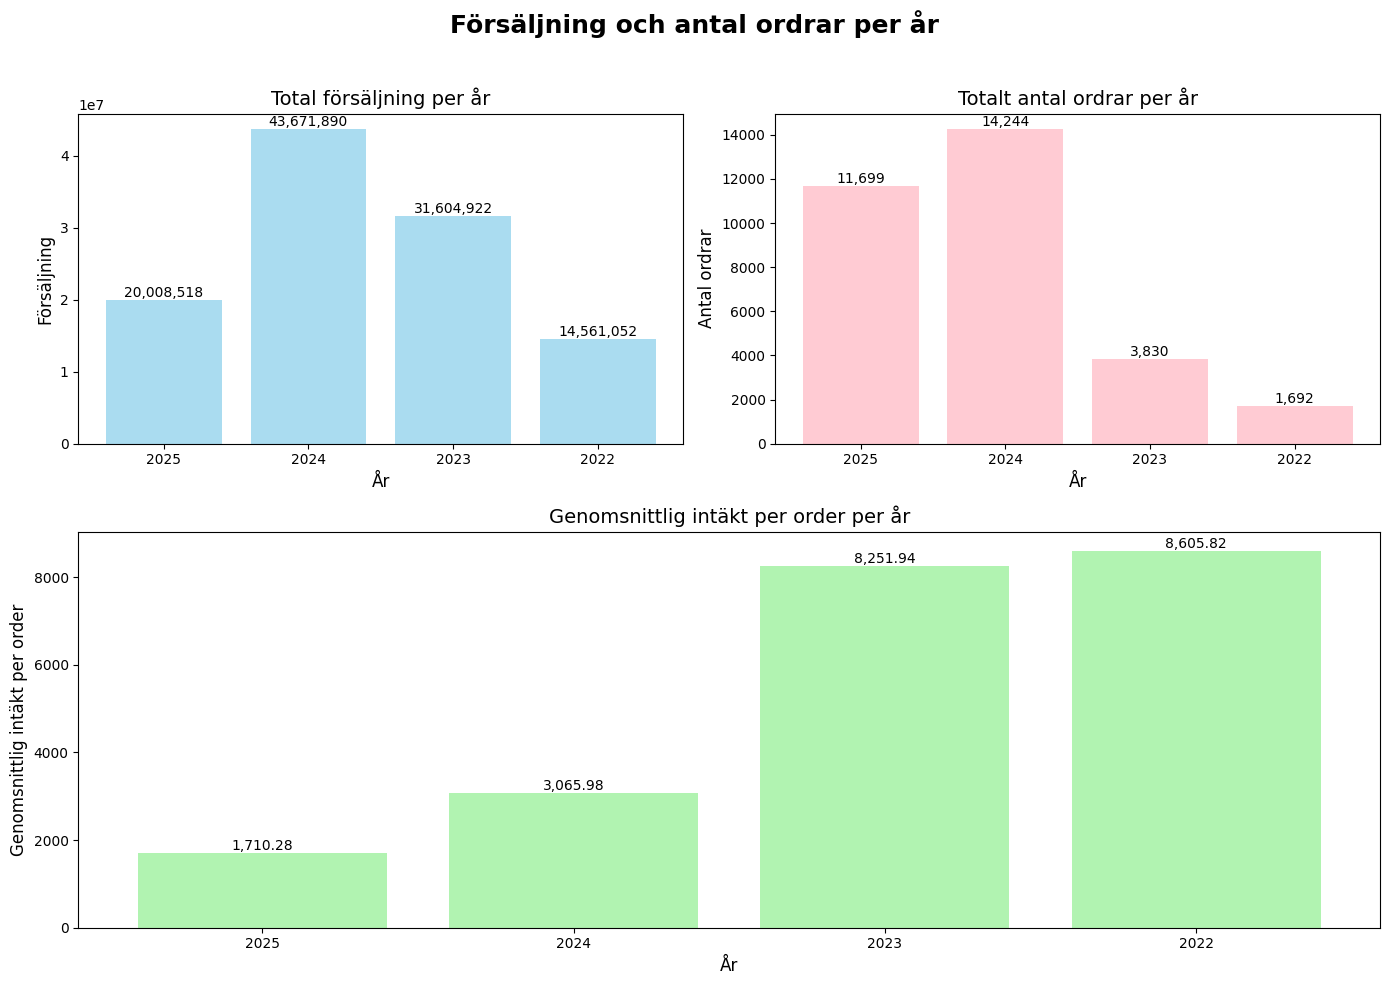

In [169]:
# Visualization 4: Sales and Orders Summary by Year
# SQL Query for Visualization 4

query_vis4 = """
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(*) AS TotalOrders,
    ROUND(SUM(SubTotal),2) AS TotalRevenue,
    (SUM(SubTotal)) / COUNT(*) AS AverageRevenuePerOrder
    
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year DESC
"""

df_vis4 = query_df(query_vis4)


fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])  # 2 rows, 2 cols, second row slightly bigger

# Total försäljning per år (Top left)
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(df_vis4['Year'].astype(str), df_vis4['TotalRevenue'], color='skyblue', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', ha='center', va='bottom')
ax1.set_title('Total försäljning per år', fontsize=14)
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Försäljning', fontsize=12)

# Totalt antal ordrar per år (Top right)
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(df_vis4['Year'].astype(str), df_vis4['TotalOrders'], color='lightpink', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,}', ha='center', va='bottom')
ax2.set_title('Totalt antal ordrar per år', fontsize=14)
ax2.set_xlabel('År', fontsize=12)
ax2.set_ylabel('Antal ordrar', fontsize=12)

# Genomsnittlig intäkt per order per år (Bottom, spanning two columns)
ax3 = fig.add_subplot(gs[1, :])
bars = ax3.bar(df_vis4['Year'].astype(str), df_vis4['AverageRevenuePerOrder'], color='lightgreen', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.2f}', ha='center', va='bottom')
ax3.set_title('Genomsnittlig intäkt per order per år', fontsize=14)
ax3.set_xlabel('År', fontsize=12)
ax3.set_ylabel('Genomsnittlig intäkt per order', fontsize=12)

fig.suptitle("Försäljning och antal ordrar per år", fontsize=18, fontweight='bold') 

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.show()


## Insikter - Försäljning och antal ordrar per år

Resultaten visar tydliga variationer mellan åren 2022 och 2025. Antalet order når sitt **maximala värde år 2024 med 14 244 order**, medan **minimivärdet återfinns år 2022 med 1 692 order**. Den totala intäkten är som **högst år 2024 med 43,7 MSEK** och som **lägst år 2022 med 14,6 MSEK**.

Den genomsnittliga intäkten per order uppvisar ett motsatt mönster, där **maximivärdet noteras år 2022 (8 605,82)** och **minimivärdet år 2025 (1 710,28)**. Det bör noteras att **data för år 2025 endast avser de första sex månaderna**, vilket kan påverka jämförbarheten med övriga år. Sammantaget indikerar resultaten en ökning i ordervolym över tid, samtidigt som den genomsnittliga intäkten per order har minskat.

## Visualisering 5: Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

**Tabeller som används:**
- Production.Product
- Sales.SalesOrderDetail
- Production.ProductCategory

**Plan:**
1. JOINA tabeller
2. Räkna intäkter per produkt
3. Räkna såld kvantitet per produkt
4. Filtrera de TOP 10 produkterna
5. Skapa horisontellt stapeldiagram
6. Analysera resultatet

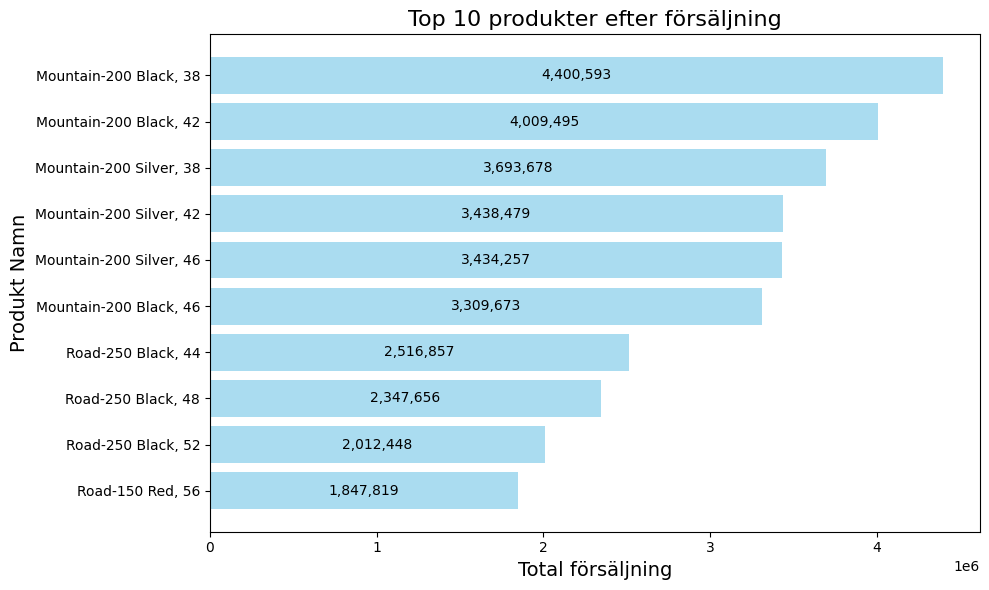

In [170]:
# Visualization 5: Top 10 Products by Sales
# SQL Query for Visualization 5

query_vis5 = """
SELECT TOP 10
    SUM(sod.OrderQty) AS QuantitySold,
    ROUND(SUM(sod.LineTotal), 2) AS TotalRevenue,
    p.Name AS ProductName,
    pc.Name AS Categorie
    
FROM Sales.SalesOrderDetail sod 
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY TotalRevenue DESC 
"""

df_vis5 = query_df(query_vis5)

# Sort DataFrame by TotalRevenue in ascending order for better visualization
df_sorted = df_vis5.sort_values(by='TotalRevenue', ascending=True)

# Horizontal Bar Chart for Top 10 Products by Sales

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    df_sorted['ProductName'],
    df_sorted['TotalRevenue'],
    color='skyblue',
    alpha=0.7
)

ax.set_title('Top 10 produkter efter försäljning', fontsize=16)
ax.set_ylabel('Produkt Namn', fontsize=14)

# Add data labels to each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width / 2,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        ha='center',
        va='center',
        color='black',
        fontsize=10
    )

ax.set_xlabel('Total försäljning', fontsize=14)
plt.tight_layout()
plt.show()


## Insikter - Top 10 produkter

Resultaten visar att samtliga topprodukter tillhör kategorin **Bikes**, vilket indikerar en tydlig dominans för denna kategori.

Den **högsta totala intäkten** genereras av **Mountain-200 Black, 38 med 4 400 592,80**, medan den **lägsta totala intäkten** återfinns för **Road-150 Red, 56 med 1 847 818,63**. Sammantaget dominerar modellerna i serien **Mountain-200** både i försäljningsvolym och intäktsbidrag jämfört med övriga produkter i urvalet.

Den **högsta sålda kvantiteten** uppnås av **Mountain-200 Black, 38 med 2 977 enheter**, medan den **lägsta sålda kvantiteten** noteras för **Road-150 Red, 56 med 664 enheter**.

## Visualisering 6: Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

**Tabeller som används:**
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

**Plan:**
1. JOINA tabeller
2. Räkna försäljning per region
3. Räkna antal unika kunder per region
4. Skapa grupperat stapeldiagram (grouped bar) med två staplar per region
5. Analysera resultatet

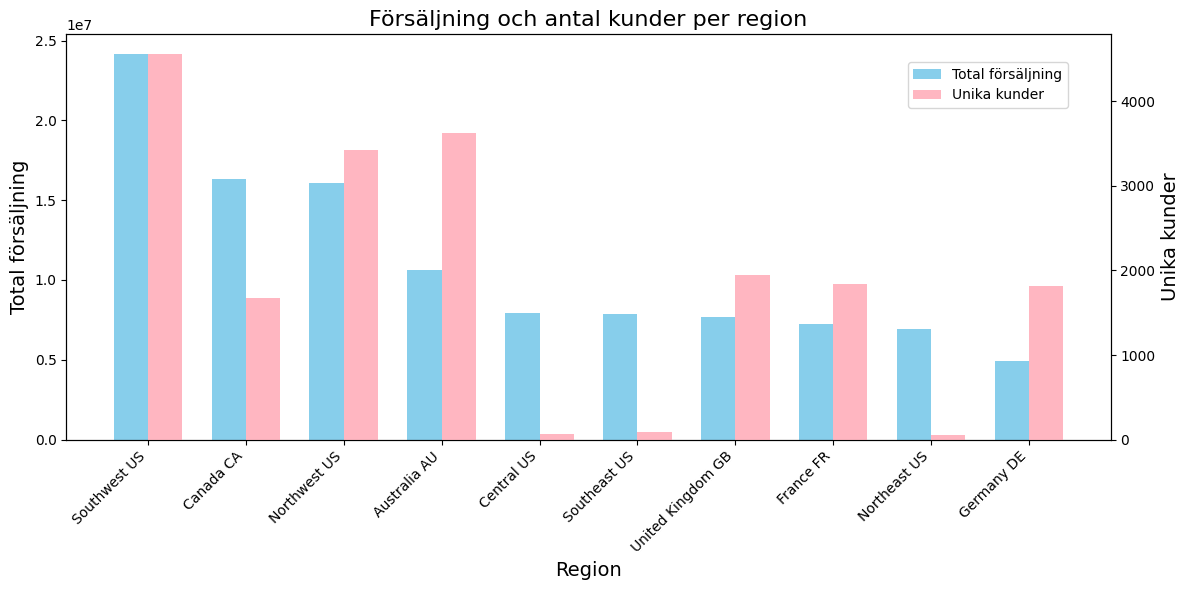

In [171]:
# Visualization 6: Sales and Customer Count by Region
# SQL Query for Visualization 6

query_vis6 = """
SELECT
    CONCAT(sst.Name,' ',sst.CountryRegionCode) AS TerritoryName,
    ROUND(SUM(soh.SubTotal),2) AS TotalRevenue,
    COUNT(DISTINCT c.CustomerID) AS AmountOfUniqueCustomer
      
    
FROM Sales.SalesOrderHeader soh 
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst ON c.TerritoryID = sst.TerritoryID
GROUP BY sst.Name, sst.CountryRegionCode
ORDER BY TotalRevenue DESC
 
"""

df_vis6 = query_df(query_vis6)


# Data for plotting
territories = df_vis6['TerritoryName']
revenue = df_vis6['TotalRevenue']
customers = df_vis6['AmountOfUniqueCustomer']

x = np.arange(len(territories))
width = 0.35

# Grouped Bar Chart for Sales and Customer Count by Region
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Create bars for revenue and customers
bars1 = ax1.bar(
    x - width/2,
    revenue,
    width,
    label='Total försäljning',
    color='skyblue'
)

bars2 = ax2.bar(
    x + width/2,
    customers,
    width,
    label='Unika kunder',
    color='lightpink'
)

ax1.set_title('Försäljning och antal kunder per region', fontsize=16)
ax1.set_xlabel('Region', fontsize=14)
ax1.set_ylabel('Total försäljning', fontsize=14)
ax2.set_ylabel('Unika kunder', fontsize=14)

ax1.set_xticks(x)
ax1.set_xticklabels(territories, rotation=45, ha='right')

# Combined legend
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

## Insikter - Försäljning och antal kunder per region

Analysen visar tydliga skillnader mellan regionerna när det gäller både total försäljning och antal unika kunder. **Southwest US** framstår som den starkaste regionen, med **högst total försäljning (24,2 MSEK)** och samtidigt **flest unika kunder (4 565)**. Detta indikerar en bred och stabil kundbas där försäljningsvolymen drivs av många kunder snarare än enbart höga ordervärden.

Den **svagaste regionen sett till total försäljning** är **Germany DE** med **4,9 MSEK**, trots ett relativt högt antal unika kunder (**1 812**). Detta tyder på ett **lägre genomsnittligt ordervärde** jämfört med flera andra regioner.

Vid en jämförelse mellan regioner framgår att den region som har högst försäljning **inte alltid** är den som har flest kunder. Exempelvis har **Canada CA** och **Northwest US** en hög total försäljning (**16,4 MSEK respektive 16,1 MSEK**) trots betydligt färre kunder än Southwest US, vilket indikerar **högre ordervärde per kund**. 

Samtidigt uppvisar **Central US**, **Southeast US** och **Northeast US** mycket låga kundantal (**57–91 kunder**) i relation till sin försäljning, vilket tyder på att intäkterna i dessa regioner sannolikt drivs av **ett fåtal kunder med mycket höga ordervärden**. Detta innebär en potentiellt hög risk, då försäljningen kan vara mer sårbar om enskilda kunder försvinner.

Sammanfattningsvis visar analysen att regioner med många kunder skapar stabilitet genom volym, medan regioner med färre kunder men relativt hög försäljning indikerar högre ordervärden per kund, men också en ökad affärsrisk.

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

**Tabeller som används:**
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

**Plan:**
1. JOINA tabeller
2. Räkna försäljning per region
3. Räkna antal ordrar per region
4. Skapa grupperat stapeldiagram (grouped bar) med två staplar per region: en för Store och en för Individual
5. Analysera resultatet

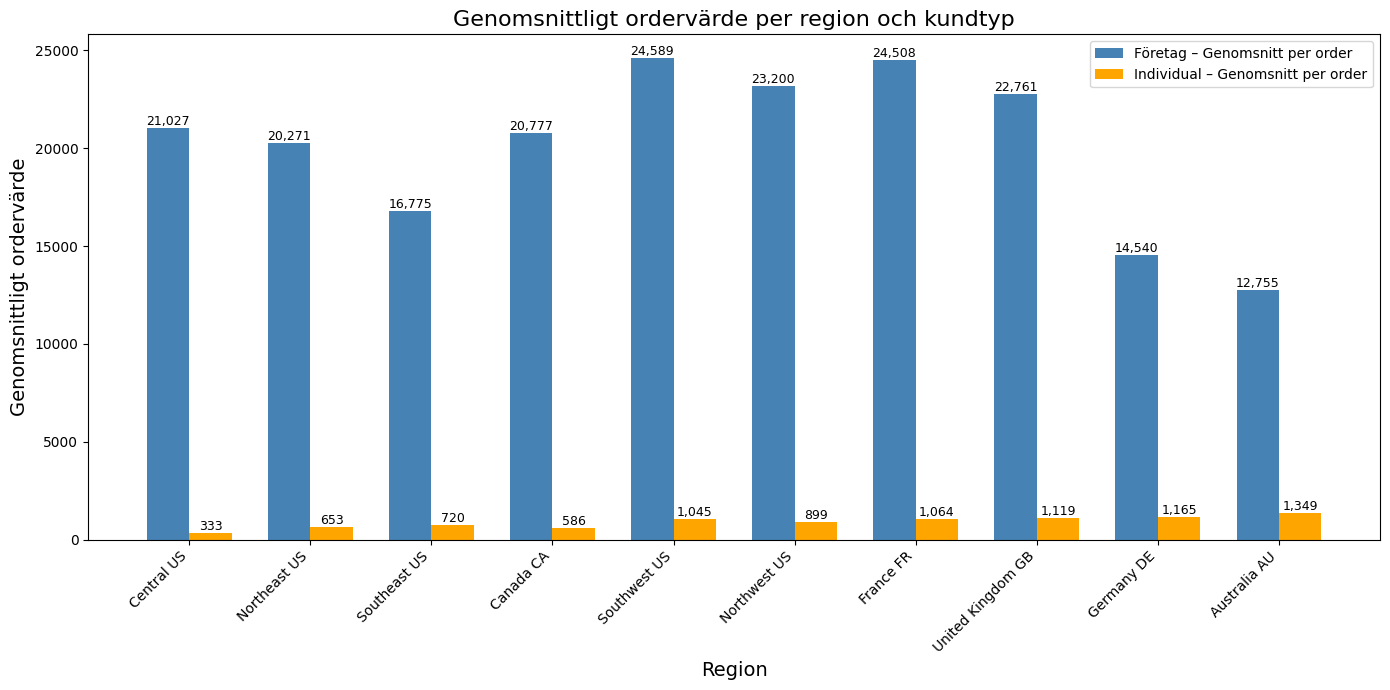

In [172]:
# Visualization 7: Average Order Value by Region and Customer Type
# SQL Query for Visualization 7

query_vis7 = """

SELECT
    CONCAT(sst.Name, ' ', sst.CountryRegionCode) AS TerritoryName,
    ROUND(SUM(SubTotal), 2) AS TotalRevenue,
    COUNT(*) AS TotalNumberOfOrders,
    ROUND(SUM(SubTotal) / COUNT(*), 2) AS AverageRevenuePerOrder,
    SUM(CASE 
        WHEN c.StoreID IS NULL THEN SubTotal
        ELSE 0 END) AS RevenueIndividus,
    SUM(CASE 
        WHEN c.StoreID IS NOT NULL THEN SubTotal
        ELSE 0 END) AS RevenueStores,
    SUM(CASE 
        WHEN c.StoreID IS NULL THEN 1
        ELSE 0 
    END) AS NbrOfOrdersIndividus,
    SUM(CASE 
        WHEN c.StoreID IS NOT NULL THEN 1
        ELSE 0 
    END) AS NbrOfOrdersStores,
    SUM(CASE 
        WHEN c.StoreID IS NULL THEN SubTotal
        ELSE 0 END)/SUM(CASE 
        WHEN c.StoreID IS NULL THEN 1
        ELSE 0 
    END) AS AvgRevPerOrderIndividus,

    SUM(CASE 
        WHEN c.StoreID IS NOT NULL THEN SubTotal
        ELSE 0 END)/SUM(CASE 
        WHEN c.StoreID IS NOT NULL THEN 1
        ELSE 0 
    END) AS AvgRevPerOrderStores

FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst ON c.TerritoryID = sst.TerritoryID
GROUP BY sst.Name, sst.CountryRegionCode
ORDER BY  AverageRevenuePerOrder DESC;
"""

df_vis7 = query_df(query_vis7)

# Data for plotting
territories = df_vis7['TerritoryName']
avg_store = df_vis7['AvgRevPerOrderStores']
avg_ind = df_vis7['AvgRevPerOrderIndividus']

x = np.arange(len(territories))
width = 0.35

# Grouped Bar Chart for Average Order Value by Region and Customer Type
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for store and individual average order values
bars_store = ax.bar(
    x - width/2,
    avg_store,
    width,
    label='Företag – Genomsnitt per order',
    color='steelblue'
)

bars_ind = ax.bar(
    x + width/2,
    avg_ind,
    width,
    label='Individual – Genomsnitt per order',
    color='orange'
)

# Show values on bars
for bars in [bars_store, bars_ind]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:,.0f}",
            ha='center',
            va='bottom',
            fontsize=9
        )


ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=16)
ax.set_xlabel('Region', fontsize=14)
ax.set_ylabel('Genomsnittligt ordervärde', fontsize=14)

ax.set_xticks(x)
ax.set_xticklabels(territories, rotation=45, ha='right')

ax.legend()

plt.tight_layout()
plt.show()


## Insikter - Genomsnittligt ordervärde per region och kundtyp

Jämförelsen visar att **Store-kunder (företag) har högre genomsnittligt ordervärde än Individual-kunder i alla regioner**. Store-order ligger generellt mellan **ca 12 700 och 24 600**, medan Individual-order ligger mellan **ca 330 och 1 350**, vilket visar en tydlig skillnad i köpbeteende.

Skillnaden är konsekvent mellan regioner, men **nivån varierar**. För Store-kunder är **lägsta genomsnittliga ordervärdet cirka 12 755 i Australia AU**, medan **högsta värdet återfinns i Southwest US med cirka 24 600**. För Individual-kunder är **lägsta genomsnittet cirka 333 i Central US** och **högsta cirka 1 349 i Australia AU**.

Skillnaderna kan förklaras av att **Store-kunder gör färre men större inköp**, ofta i bulk eller genom avtal, medan **Individual-kunder gör fler men mindre köp** av enskilda produkter.

Den **högsta kombinationen av region och kundtyp** är **Store i Southwest US**, vilket gör denna kombination till den mest värdeskapande per order i analysen.


## Visualisering ALTERNATIV A: Regional försäljningsoptimering
# Vilka produktkategorier säljer bäst var?

**Tabeller som används:**
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.SalesOrderDetail
- Production.Product
- Production.ProductCategory
- Production.ProductSubcategory


**Plan:**
1. JOINA tabeller
2. Räkna försäljning per region och produktkategorie
3. Skapa Skapa en heatmap för försäljning per region och kategori.

# Finns säsongsmönster per region?

**Tabeller som används:**
- Sales.SalesOrderHeader 
- Sales.SalesTerritory
- Sales.Customer

**Plan:**
1. JOINA tabeller
2. Räkna  försäljning per region per månader
3. Lägg till ett filter för att endast visa de senaste 13 fulla månaderna
4. Skapa linjediagram

# Hur ser intäker för våra Top 4 regioner ut?

**Tabeller som används:**
- Sales.SalesOrderHeader 
- Sales.SalesTerritory
- Sales.Customer


**Plan:**
1. JOINA tabeller
2. Räkna försäljning per region per månader
3. Lägg till ett filter för att endast visa de senaste 13 fulla månaderna
4. Lägg till ett filter för företagsförselning
5. Lägg till ett filter för indivduell förselning
6. Skapa linjediagram
7. Analysera alla resultat

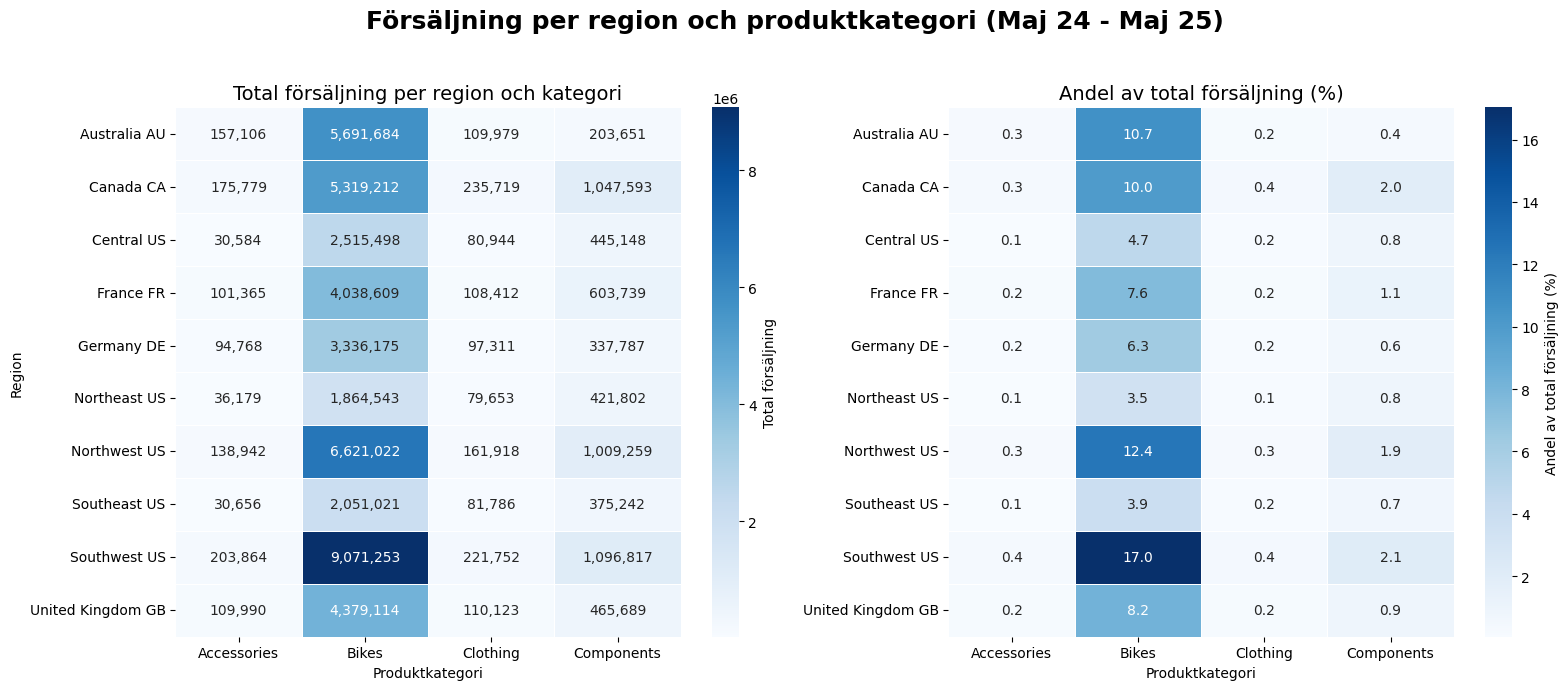

In [173]:
# Visualization A1: Sales by Region and Product Category Heatmap
# SQL Query for Visualization A1

query_visA1 = """
SELECT
    CONCAT(sst.Name, ' ', sst.CountryRegionCode) AS TerritoryName,
    pc.Name AS CategoryName,
    ROUND(SUM(sod.LineTotal), 2) AS TotalRevenue


FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst ON c.TerritoryID = sst.TerritoryID
INNER JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE OrderDate >= DATEADD(
        MONTH,
        -13,
        DATEADD(
            MONTH,
            DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
            0
        )
      )
  AND OrderDate < DATEADD(
        MONTH,
        DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
        0
      )
GROUP BY sst.Name, sst.CountryRegionCode, pc.Name
ORDER BY  TotalRevenue DESC;
"""

df_visA1 = query_df(query_visA1)

# Pivot table: Region × Category (absolute values)
heatmap_abs = df_visA1.pivot_table(
    index='TerritoryName',
    columns='CategoryName',
    values='TotalRevenue',
    aggfunc='sum'
)

# Percentage of total revenue
heatmap_pct = heatmap_abs / heatmap_abs.sum().sum() * 100

# Create dashboard
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Absolute revenue heatmap
sns.heatmap(
    heatmap_abs,
    annot=True,
    fmt=",.0f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Total försäljning'},
    ax=axes[0]
)
axes[0].set_title("Total försäljning per region och kategori", fontsize=14)
axes[0].set_xlabel("Produktkategori")
axes[0].set_ylabel("Region")

# Percentage heatmap
sns.heatmap(
    heatmap_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Andel av total försäljning (%)'},
    ax=axes[1]
)
axes[1].set_title("Andel av total försäljning (%)", fontsize=14)
axes[1].set_xlabel("Produktkategori")
axes[1].set_ylabel("")

# Main title
fig.suptitle("Försäljning per region och produktkategori (Maj 24 - Maj 25)", fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

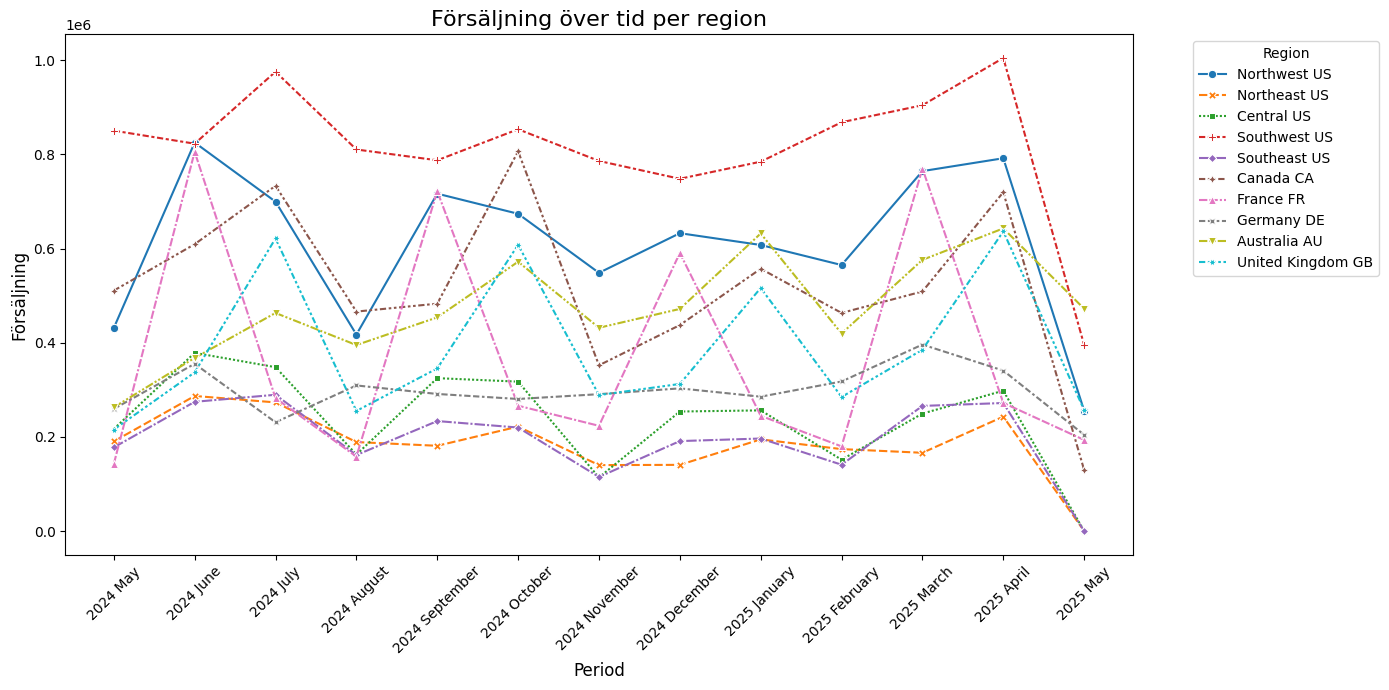

In [174]:
# Visualization A2: Sales Over Time by Region
# SQL Query for Visualization A2

query_visA2 = """
SELECT 
    CONCAT(sst.Name, ' ', sst.CountryRegionCode) AS TerritoryName,
    ROUND(SUM(SubTotal), 2) AS TotalRevenue,
    YEAR(OrderDate) AS [Year],
    RIGHT('00' + CAST(MONTH(OrderDate) AS varchar(2)), 2) AS [Month],
    FORMAT(OrderDate, 'yyyyMM') AS Period,
    FORMAT(OrderDate, 'yyyy MMMM') AS PeriodName
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst ON c.TerritoryID = sst.TerritoryID

WHERE OrderDate >= DATEADD(
        MONTH,
        -13,
        DATEADD(
            MONTH,
            DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
            0
        )
      )
  AND OrderDate < DATEADD(
        MONTH,
        DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
        0
      )
GROUP BY 
    sst.Name, sst.CountryRegionCode,
    YEAR(OrderDate),
    MONTH(OrderDate),
    FORMAT(OrderDate, 'yyyyMM'),
    FORMAT(OrderDate, 'yyyy MMMM')
ORDER BY Period ASC
"""

df_visA2 = query_df(query_visA2)

# Line Chart for Sales Over Time by Region
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_visA2,
    x='PeriodName',
    y='TotalRevenue',
    hue='TerritoryName',
    style='TerritoryName',      # different line styles
    markers=True               # markers on each point
)

plt.title("Försäljning över tid per region", fontsize=16)
plt.xlabel("Period", fontsize=12)
plt.ylabel("Försäljning", fontsize=12)

plt.xticks(rotation=45)
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

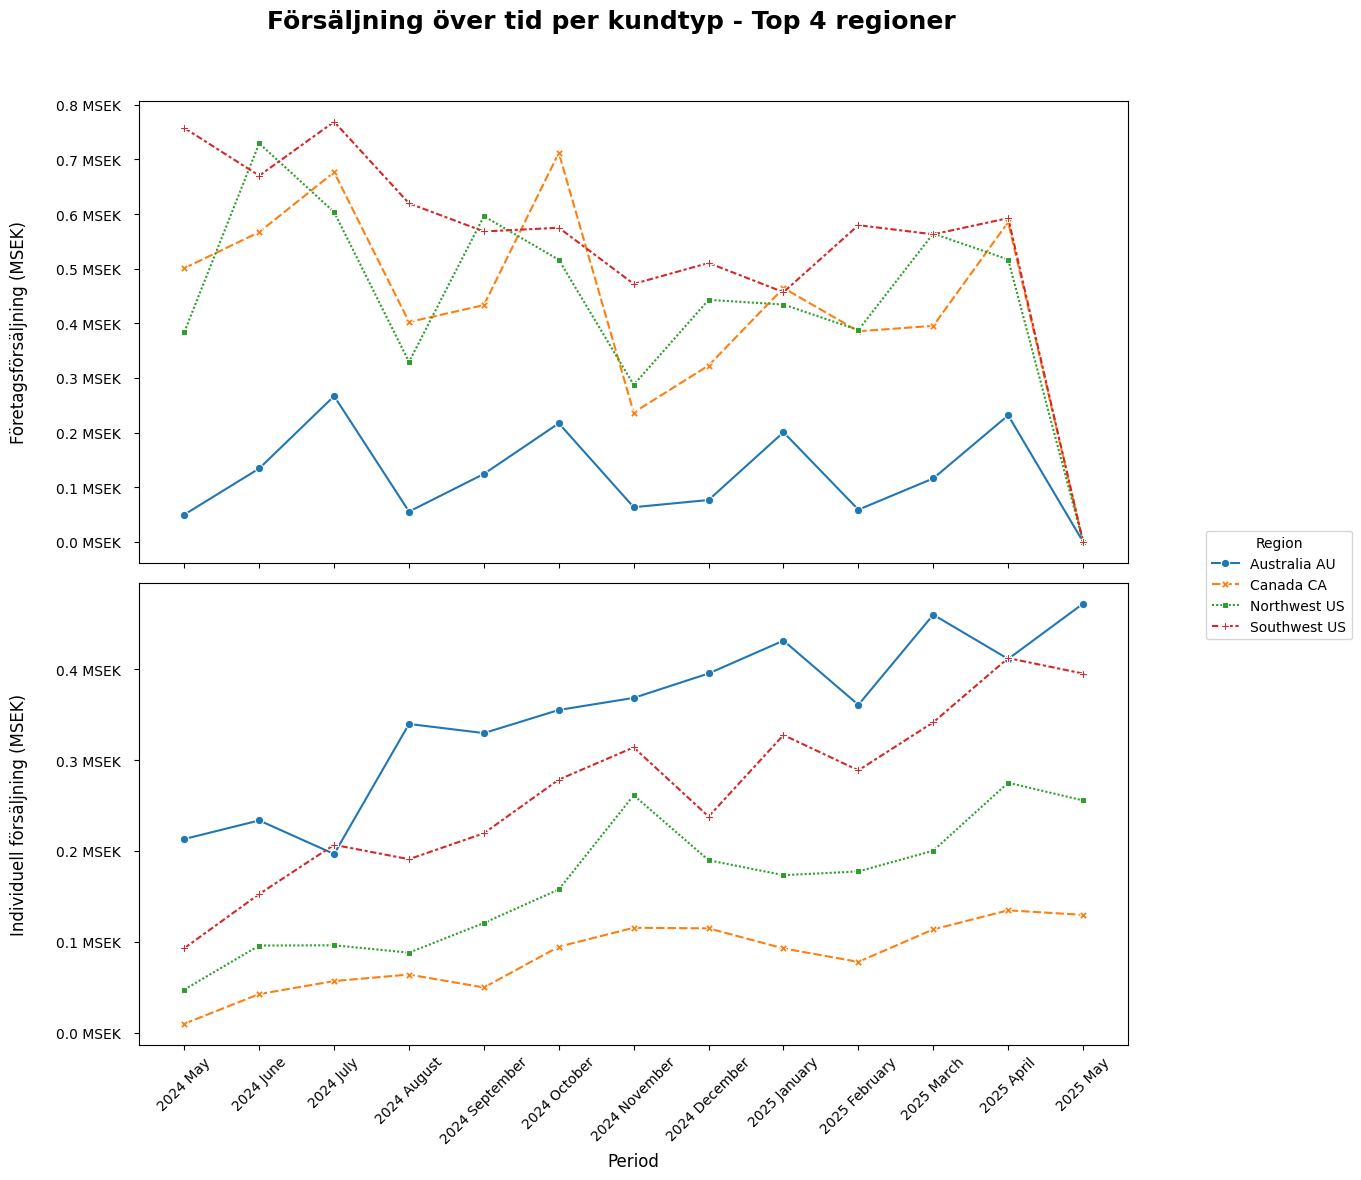

In [175]:
# Visualization A3 & A4: Sales Over Time by Customer Type in Top 4 Regions
# SQL Query for Visualization A3

query_visA3 = """
WITH Top4Territories AS (
    SELECT TOP 4
        c.TerritoryID
    FROM Sales.SalesOrderHeader soh
    INNER JOIN Sales.Customer c 
        ON soh.CustomerID = c.CustomerID
    GROUP BY c.TerritoryID
    ORDER BY SUM(soh.SubTotal) DESC
)

SELECT 
    CONCAT(sst.Name, ' ', sst.CountryRegionCode) AS TerritoryName,
    SUM(CASE 
        WHEN c.StoreID IS NOT NULL THEN soh.SubTotal
        ELSE 0 
    END) AS RevenueStores,
    YEAR(soh.OrderDate) AS [Year],
    RIGHT('00' + CAST(MONTH(soh.OrderDate) AS varchar(2)), 2) AS [Month],
    FORMAT(soh.OrderDate, 'yyyyMM') AS Period,
    FORMAT(soh.OrderDate, 'yyyy MMMM') AS PeriodName
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.Customer c 
    ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst 
    ON c.TerritoryID = sst.TerritoryID
INNER JOIN Top4Territories t4
    ON c.TerritoryID = t4.TerritoryID
WHERE soh.OrderDate >= DATEADD(
        MONTH,
        -13,
        DATEADD(
            MONTH,
            DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
            0
        )
      )
  AND soh.OrderDate < DATEADD(
        MONTH,
        DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
        0
      )
GROUP BY 
    sst.Name, 
    sst.CountryRegionCode,
    YEAR(soh.OrderDate),
    MONTH(soh.OrderDate),
    FORMAT(soh.OrderDate, 'yyyyMM'),
    FORMAT(soh.OrderDate, 'yyyy MMMM')
ORDER BY Period ASC;
"""

# SQL Query for Visualization A4

query_visA4 ="""
WITH Top4Territories AS (
    SELECT TOP 4
        c.TerritoryID
    FROM Sales.SalesOrderHeader soh
    INNER JOIN Sales.Customer c 
        ON soh.CustomerID = c.CustomerID
    GROUP BY c.TerritoryID
    ORDER BY SUM(soh.SubTotal) DESC
)

SELECT 
    CONCAT(sst.Name, ' ', sst.CountryRegionCode) AS TerritoryName,
    SUM(CASE 
        WHEN c.StoreID IS NULL THEN soh.SubTotal
        ELSE 0 
    END) AS RevenueIndividus,
    YEAR(soh.OrderDate) AS [Year],
    RIGHT('00' + CAST(MONTH(soh.OrderDate) AS varchar(2)), 2) AS [Month],
    FORMAT(soh.OrderDate, 'yyyyMM') AS Period,
    FORMAT(soh.OrderDate, 'yyyy MMMM') AS PeriodName
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.Customer c 
    ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst 
    ON c.TerritoryID = sst.TerritoryID
INNER JOIN Top4Territories t4
    ON c.TerritoryID = t4.TerritoryID
WHERE soh.OrderDate >= DATEADD(
        MONTH,
        -13,
        DATEADD(
            MONTH,
            DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
            0
        )
      )
  AND soh.OrderDate < DATEADD(
        MONTH,
        DATEDIFF(MONTH, 0, (SELECT MAX(OrderDate) FROM Sales.SalesOrderHeader)),
        0
      )
GROUP BY 
    sst.Name, 
    sst.CountryRegionCode,
    YEAR(soh.OrderDate),
    MONTH(soh.OrderDate),
    FORMAT(soh.OrderDate, 'yyyyMM'),
    FORMAT(soh.OrderDate, 'yyyy MMMM')
ORDER BY Period ASC;

"""


df_visA3 = query_df(query_visA3)
df_visA4 = query_df(query_visA4)


# Formatter for MSEK
def format_msek(x, pos):
    return f'{x/1_000_000:.1f} MSEK'

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Företagsförsäljning (Store)
sns.lineplot(
    data=df_visA3,
    x='PeriodName',
    y='RevenueStores',
    hue='TerritoryName',
    style='TerritoryName',
    markers=True,
    ax=axes[0]
)


axes[0].set_ylabel("Företagsförsäljning (MSEK)", fontsize=12, labelpad=20)
axes[0].yaxis.set_major_formatter(FuncFormatter(format_msek))
axes[0].tick_params(axis='y', pad=10)
axes[0].legend_.remove()  # ❌ remove legend

# Individuell försäljning (Individual)
sns.lineplot(
    data=df_visA4,
    x='PeriodName',
    y='RevenueIndividus',
    hue='TerritoryName',
    style='TerritoryName',
    markers=True,
    ax=axes[1]
)


axes[1].set_xlabel("Period", fontsize=12)
axes[1].set_ylabel("Individuell försäljning (MSEK)", fontsize=12, labelpad=20)
axes[1].yaxis.set_major_formatter(FuncFormatter(format_msek))
axes[1].tick_params(axis='y', pad=10)
axes[1].legend_.remove()  # remove legend

# Shared legend (single, clean)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Region",
    loc="center left",
    bbox_to_anchor=(0.92, 0.5)
)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Main title
fig.suptitle(
    "Försäljning över tid per kundtyp - Top 4 regioner",
    fontsize=18,
    fontweight='bold'
)

# Balanced layout with extra left margin
plt.tight_layout(rect=[0.06, 0, 0.88, 0.95])

plt.show()

## Insikter - Regional försäljningsoptimering

## Total Revenue (13 senaste månaderna)
- **Högintäktregioner:**  
  - Southwest US – 10,593,685  
  - Northwest US – 7,931,141  
  - Kanada – 6,778,303  
  - Australien – 6,162,420  

- **Lägre intäktsregioner:**  
  - Southeast US – 2,538,706  
  - Northeast US – 2,402,177  
  - Central US – 3,072,175  

**Kommentar:** Southwest och Northwest US dominerar, medan östra och centrala regioner har betydligt lägre intäkter.

## Regioners Risker

- **Southwest US & Northwest US:**  
  - Risk: Stora delar av butiksförsäljningen verkar stoppad i maj, vilket kan påverka intäkterna om orderstopp kvarstår.  
  - Operativ risk vid störningar i lager eller transport.  

- **Kanada & Australien:**  Risk: Hög beroende av individuell försäljning. Eventuella förändringar i online-kundbeteende kan påverka intäkterna kraftigt.  

- **Southeast, Northeast och Central US:**  
  - Risk: Låg total revenue och butiksnärvaro gör att regionerna är sårbara för marknadsförändringar och konkurrens.  
  - Möjlighet: Förbättrad butiksexponering och marknadsföringsinsatser kan snabbt öka försäljningen.  

- **UK, Tyskland och Frankrike:** Risk: Stabil men måttlig tillväxt. Starka marknader men påverkas av internationella logistikutmaningar och valutafluktuationer.

## Regioners Möjligheter

- **High revenue regions (Southwest US, Northwest US, Kanada, Australien):**  
  - Expandera individuell försäljning för att kompensera för butiksstopp.  
  - Säsongsbaserade kampanjer kan maximera intäkter under högsäsong.  

- **Low revenue regions (Southeast, Northeast, Central US):**  
  - Investera i butiksnärvaro och lokal marknadsföring.  
  - Introducera nya kampanjer eller produktpaket för att driva tillväxt.  

- **Global expansion:**  
  - Australien och Kanada visar starka siffror trots begränsad befolkning, vilket indikerar möjligheter för vidare geografisk expansion eller premiumsegment.  

## Rekommendationer

1. Återställ butikstillgänglighet där orderstopp förekommer (maj 2025).  
2. Prioritera digitala kanaler i high-revenue regioner för att säkra intäkter.  
3. Stärk marknadsföring och butiksexponering i low-revenue regioner.  
4. Implementera riskhantering för logistik, valutaförändringar och säsongsvariationer.  
5. Analysera kundtrender per region för att identifiera tillväxtmöjligheter och förebygga intäktsfall.

**Slutsats:**  
Southwest US, Northwest US, Kanada och Australien driver intäkterna, men butiksstopp och beroende av onlineförsäljning är tydliga risker. Southeast, Northeast och Central US har stor uppsida om butiksnärvaro och marknadsföring förbättras. Strategiska satsningar på både online och butik kan maximera tillväxt och minimera regional risk.
